## UDP Traceroute Connectivity by Probe

This notebook uses _existing_ RIPE Atlas measurements to determine how many RIPE Atlas probes might have issues with UDP connectivity. The basic methodology is as follows:

- Examine measurement metadata to find UDP traceroutes from many probes, over time (currently measurements ending in 2015, or still ongoing).
- Take latency to target and target reachability information from each sample. For samples where the target is not reached but some hops did respond, take the latest hop.
- Group reachability information by probe, and classify probes by how confident we are UDP is broken on them.

This notebook searches the RIPE atlas measurement metadata archive (available from [ftp.ripe.net](ftp://ftp.ripe.net/atlas/measurements)) for UDP and TCP traceroute measurements, and uses the Atlas API to download measurements and cache them locally.

### Preamble

Set up the environment and define functions we'll use later.

In [1]:
# Some jupyter magic to set up the environment correctly
%load_ext autoreload
%autoreload 2
%matplotlib inline

# thanks for letting me know about your plans but i don't really care
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

# things we need, things to make us go
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import collections
import warnings
import hashlib
import requests
import os.path
import time
import calendar
import itertools
import json

# HDF5 store for stashing parsed things
store = pd.HDFStore('data_cache/udp_traceconn.h5')

##############################################################################
# Trace metadata named tuple, probe to MSM mapping named tuple,
# and generator for extracting these from the all-measurements-fjson.txt file.
##############################################################################

TraceMeta = collections.namedtuple("TraceMeta", 
                ("msm_id", "af", "proto", "target", 
                 "start_epoch", "stop_epoch", "interval", "probes"))

MSMProbeMeta = collections.namedtuple("MSMProbeMeta", ("msm_id", "pid"))

def tm_generator(first_start=0, last_start=calendar.timegm(time.gmtime()), skip_lines = 0):
    current_time = calendar.timegm(time.gmtime())
    
    with open("data_cache/all-measurements-fjson.txt") as fjf:
        for num, line in enumerate(fjf):
            if num < skip_lines:
                continue
            
            mm = json.loads(line)
                
            if (((mm['type']['id'] == 2) or (mm['type']['id'] == 4)) and
                ((mm['status']['id'] == 2) or (mm['status']['id'] == 4)) and
                (('protocol' in mm) or ('proto_tcp' in mm)) and
                (mm['start_time'] >= first_start) and
                (mm['start_time'] < last_start) ):
            
                    if mm['status']['id'] == 4:
                        stop_time = mm['stop_time']
                    else:
                        stop_time = current_time
                    
                    if 'proto_tcp' in mm and mm['proto_tcp']:
                        proto = 'TCP'
                    else:
                        proto = mm['protocol']
                        
                    yield TraceMeta(mm['msm_id'], mm['af'], proto, mm['dst_addr'], 
                                    mm['start_time'], stop_time, mm['interval'],
                                    mm['participant_count'])

def mpm_generator(msm_ids, skip_lines = 0):
    current_time = calendar.timegm(time.gmtime())

    with open("data_cache/all-measurements-fjson.txt") as fjf:
        for num, line in enumerate(fjf):
            if num < skip_lines:
                continue
        
            mm = json.loads(line)
            if (mm['msm_id'] in msm_ids):
                if "probes" in mm:
                    for p in mm["probes"]:
                        yield MSMProbeMeta(mm['msm_id'], p['id'])
                        
def mpm_dataframe(msm_ids, chunksize=1000000):
    # initialize MPM generator
    mpmgen = mpm_generator(msm_ids)
    
    # initialize accumulators
    df = pd.DataFrame([], columns=MSMProbeMeta._fields)
    data = []
    chunk_count = 0
    
    # get individual rows from get_msm
    for mpm in mpmgen:
        data.append(mpm)
        if len(data) >= chunksize:
            df = df.append(pd.DataFrame(data, columns=MSMProbeMeta._fields), ignore_index=True)
            data = []
            print("chunk "+str(chunk_count))
            chunk_count += 1
                    
    # Append final dataframe if non-empty.
    if len(data) > 0:
        df = df.append(pd.DataFrame(data, columns=MSMProbeMeta._fields), ignore_index=True)

    # Close generator (close underlying file)
    mpmgen.close()
    
    # Return dataframe
    return df

##############################################################################
# Probe metadata named tuple and extraction code
##############################################################################
AtlasProbe = collections.namedtuple("AtlasProbe",
           ("pid", "version", "nat", "ip4", "ip6", "asn4", "asn6", "cc", "lat", "lon"))

def extract_atlas_probe(pobj):
    if "address_v4" in pobj:
        ip4 = pobj["address_v4"]
    else:
        ip4 = None

    if "address_v6" in pobj:
        ip6 = pobj["address_v6"]
    else:
        ip6 = None

    if "asn_v4" in pobj:
        asn4 = pobj["asn_v4"]
    else:
        asn4 = None

    if "asn_v6" in pobj:
        asn6 = pobj["asn_v6"]
    else:
        asn6 = None

    if "tags" in pobj:
        if "system-v1" in pobj["tags"]:
            version = 1
        elif "system-v2" in pobj["tags"]:
            version = 2
        elif "system-v3" in pobj["tags"]:
            version = 3
        elif "system-anchor" in pobj["tags"]:
            version = 4
        else:
            version = 0

        nat = "nat" in pobj["tags"]


    return AtlasProbe(pobj["id"], version, nat, ip4, ip6, asn4, asn6,
                      pobj["country_code"], pobj["latitude"], pobj["longitude"])       

def probe_dataframe_from_file(filename="data_cache/all-probes.json"):
    data = []
    
    # make a giant array
    with open(filename) as stream:
        all_probes = json.loads(stream.read())
        for pobj in all_probes["objects"]:
            data.append(extract_atlas_probe(pobj))

    # create a dataframe from it
    df = pd.DataFrame(data, columns=AtlasProbe._fields)
    
    # indexed by probe ID
    df.index = df['pid']
    del(df['pid'])
    
    # stick an aggregation column on there, we'll use it later
    df['n'] = 1
    
    # and return it
    return df

##############################################################################
# MSM retrieval code
##############################################################################

def get_msm(msm_id, gen, cachedir=None, start=None, stop=None):
    """
    Given an MSM, fetch it from the cache or from the RIPE Atlas API.
    Yield each separate result according to the generation function.
    """
    url = "https://atlas.ripe.net/api/v1/measurement/%u/result/" % (msm_id,)

    params = {"format": "json"}
    if start is not None and stop is not None:
        params["start"] = str(start)
        params["stop"] = str(stop)
    
    if cachedir and os.path.isdir(cachedir):
        filepath = os.path.join(cachedir, "measurement", "%u.json" % (msm_id,))

        # download if not present
        if not os.path.isfile(filepath):
            with open(filepath, mode="wb") as file:
                print("Cache miss, retrieving "+url)
                res = requests.get(url, params=params)

                if not res.ok:
                    raise "Atlas measurement API request failed: "+repr(res.json())
                
                file.write(res.content)

        # then read from cache
        with open(filepath) as stream:
            yield from gen(json.loads(stream.read()))

    else:
        # just read from the net
        res = requests.get(url, params=params)
        yield from gen(json.loads(res.content.decode("utf-8")))

##############################################################################
# Connectivity sample named tuple,
# connectivity sample generator for use with get_msm(),
# and dataframe creation function wrapping all of this together
##############################################################################

TCSample = collections.namedtuple("TCSample",
                     ("msm_id","time","af","proto","pid","sip","dip","reached","hop","rtt"))

def gen_tcs(msm_ary):
    for a_res in msm_ary:        
        if a_res['type'] == 'traceroute':
            if ('result' in a_res):
                maxhop = 0
                maxhop_ok = False
                for hop in a_res['result']:
                    if 'result' in hop:
                        for pkt in hop['result']:
                            if 'from' in pkt:
                                maxhop = hop['hop']
                                if pkt['from'] == a_res['dst_addr']:
                                    maxhop_ok = True
                                    if 'rtt' in pkt:
                                        rtt = pkt['rtt']
                                    else:
                                        rtt = -1
                                    yield TCSample(a_res['msm_id'],
                                           int(a_res['timestamp']), a_res['af'], a_res['proto'],
                                           a_res['prb_id'], a_res['src_addr'], a_res['dst_addr'],
                                           True, maxhop, rtt)
                                    break
                if not maxhop_ok:
                    try:
                        yield TCSample(a_res['msm_id'],
                                       int(a_res['timestamp']), a_res['af'], a_res['proto'],
                                       a_res['prb_id'], a_res['src_addr'], a_res['dst_addr'],
                                       False, maxhop, -1)
                    except KeyError:
                        # ignore completely broken results
                        pass

def tcsample_dataframe(msm_ids, cachedir=None, start=None, stop=None, chunksize=1000000):
    """
    Given an iterable of MSMs, create a dataframe of trace connectivity samples.
    """
    
    # initialize accumulators
    adf = pd.DataFrame([], columns=TCSample._fields)
    data = []
    
    # get individual rows from get_msm
    for msm_id in msm_ids:
        for tcs in get_msm(msm_id, gen=gen_tcs, 
                           start=start, stop=stop, 
                           cachedir=cachedir):
            data.append(tcs)
            
            # Append dataframe to dataframe accumulator if chunking.
            if len(data) >= chunksize:
                adf = adf.append(pd.DataFrame(data, columns=TCSample._fields), ignore_index=True)
                data = []
                
    # Append final dataframe if non-empty.
    if len(data) > 0:
        adf = adf.append(pd.DataFrame(data, columns=TCSample._fields), ignore_index=True)

    # Counter column for aggregation
    adf['n'] = 1
    
    return adf

##############################################################################
# Plotting utility function
##############################################################################

def plot_ecdf(a, **kwargs):
    sa = np.sort(a)
    yv = np.arange(len(sa))/float(len(sa))
    plt.plot(sa, yv, **kwargs)

### Step 1b, 2b: store/restore preparsed raw dataframes in HDF

Do this instead of steps 1 and 2 if not reworking parsing and raw dataframs selection. It's silly fast.

In [13]:
## Restore pre-parsed dataframes from the store, and re-split them as necessary
%time tmdf = store['tmdf']
%time tcsdf15 = store['tcsdf']
%time ut46df = store['feb_tcsdf']

CPU times: user 329 ms, sys: 204 ms, total: 533 ms
Wall time: 533 ms
CPU times: user 1.13 s, sys: 499 ms, total: 1.62 s
Wall time: 1.62 s
CPU times: user 135 ms, sys: 66.1 ms, total: 201 ms
Wall time: 201 ms


### Step 1: find MSM ids for UDP traceroutes 

Here we limit ourselves to MSMs run (1) from many probes, to maximize the number of probes we'll see samples from, and (2) ending in 2015 or later, to focus on the recent past. Note that many of these are MSMs we specified ourselves for our TMA paper. Not many people seem to be interested in UDP traceroute.

In [ ]:
# get ALL the traceroutes! (takes about five minutes on Forclaz)
tmgen = tm_generator()
%time tmdf = pd.DataFrame([m for m in tmgen], columns=TraceMeta._fields)
tmgen.close() # generator wraps a file, close it.

# estimate sample count
tmdf['samples'] = (tmdf['probes'] * (tmdf['stop_epoch'] - tmdf['start_epoch'])) / tmdf['interval']

# cast timestamps
tmdf['start'] = pd.to_datetime(tmdf['start_epoch'] * 1e9)
tmdf['stop'] = pd.to_datetime(tmdf['stop_epoch'] * 1e9)
tmdf['duration'] = tmdf['stop'] - tmdf['start']

# count msms
tmdf['n'] = 1

# index by msm
tmdf.index = pd.Index(tmdf['msm_id'])
del(tmdf['msm_id'])

# Dump dataframe into the HDF store
store['tmdf'] = tmdf

# exclude all measurements ending before 1 Jan 2015, and split by protocol
tmdf_udp = tmdf[tmdf['proto'] == 'UDP']
tmdf_udp = tmdf_udp[tmdf_udp["stop"] >= "2015-01-01"]
tmdf_tcp = tmdf[tmdf['proto'] == 'TCP']
tmdf_tcp = tmdf_tcp[tmdf_tcp["stop"] >= "2015-01-01"]
tmdf_icmp = tmdf[tmdf['proto'] == 'TCP']
tmdf_icmp = tmdf_icmp[tmdf_icmp["stop"] >= "2015-01-01"]

# find appropriate MSMs
msm_ids = tmdf_udp[tmdf_udp['probes'] >= 64].index.values

### Step 2: Retrieve MSMs and parse them into a dataframe

First grab all UDP traceroutes from 2015 on. Then grab UDP and TCP traceroutes from our Feb 2016 run.

In [ ]:
%time tcsdf15 = tcsample_dataframe(msm_ids, cachedir="data_cache", chunksize=100000)
store['tcsdf'] = tcsdf

In [ ]:
NEW_MSMS = range(3354201,3354261)
%time ut46df = tcsample_dataframe(NEW_MSMS, cachedir="data_cache", chunksize=100000)
store['feb_tcsdf'] = ut46df

### Step 3: classify 2015 probe IDs by UDP reachability 

First, clean the data: drop all samples from MSMs where no traceroute reached the target (target always down), then all samples from probes with less than n=9 samples.

In [3]:
def clean_tcs(df, min_pid_sample_count=9):
    msm_reached_sum = df.groupby('msm_id')['reached'].sum()
    bad_target_msm_ids = msm_reached_sum[msm_reached_sum == 0].index
    df_target_udp_ok = df[np.logical_not(df['msm_id'].isin(bad_target_msm_ids))]
    
    pid_sum = df.groupby('pid')['n'].sum()
    low_volume_pids = pid_sum[pid_sum < min_pid_sample_count].index
    return df_target_udp_ok[np.logical_not(df_target_udp_ok['pid'].isin(low_volume_pids))]

tcsdf15_clean = clean_tcs(tcsdf15)

Then load information about the probes

In [4]:
pdf = probe_dataframe_from_file()

Headline number: how many probes might block UDP?

In [23]:
def blocked_pids(df):
    reached_by_pid = df.groupby('pid')['reached'].sum()
    return reached_by_pid[reached_by_pid == 0].index


print ("%u / %u (%5.3f%%)" %   (len(blocked_pids(tcsdf15_clean)),
                                len(tcsdf15_clean['pid'].unique()),
                               100 * (len(blocked_pids(tcsdf15_clean)) / len(tcsdf15_clean['pid'].unique()))))

pdf_tcsdf = pdf.loc[tcsdf15_clean['pid'].unique()]
pdf_noudp = pdf.loc[udp_blocked_pids(tcsdf15_clean)]

82 / 2240 (3.661%)


In [11]:
# Get all samples from potentially UDP-blocked probes
tcsdf_blocked = tcsdf15_clean[tcsdf15_clean['pid'].isin(pdf_noudp.index)]

# add sample count, minhop, and maxhop to probe DF for UDP blockage
pdf_noudp = pd.merge(pdf_noudp, pd.DataFrame(data = {"samples": tcsdf_blocked.groupby('pid')["n"].sum(),
                                         "minhop":  tcsdf_blocked.groupby('pid')["hop"].min(),
                                         "maxhop":  tcsdf_blocked.groupby('pid')["hop"].max()}),
                     left_index = True, right_index = True, how="inner")

Which probes are affected?

In [12]:
pdf_noudp

,version,nat,ip4,ip6,asn4,asn6,cc,lat,lon,n,maxhop,minhop,samples
pid,,,,,,,,,,,,,
637,1,False,195.189.0.242,2a02:7a00:0:5:220:4aff:febf:ff8e,39904,39904,CZ,49.5905,17.2685,1,32,0,1713
689,1,True,None,None,1221,NaN,AU,-33.6685,150.9415,1,255,1,96
720,1,True,None,None,34554,34554,CH,47.2875,8.8385,1,255,0,1104
1004,1,True,203.168.164.86,None,9908,NaN,HK,22.2495,114.1675,1,0,0,329
1121,1,True,70.121.52.175,2001:470:1f0f:cf7:220:4aff:fec7:b076,11427,6939,US,32.9075,-96.6415,1,13,13,1
1270,1,True,None,None,8681,NaN,JE,49.2075,-2.1295,1,1,1,96
2577,2,True,109.232.72.250,2a00:19f8:10:50:220:4aff:fee0:22a5,49010,49010,DK,56.2605,9.5005,1,2,1,591
2601,2,True,212.52.131.242,None,25543,NaN,BF,12.3775,-1.5025,1,0,0,1270
2844,2,False,None,None,49362,NaN,HK,22.2795,114.2695,1,6,0,239


Not yet clear how to classify these based on last hop -- but there's definitely a difference between small hop counts and big ones. Look at AS path distances?

### Step 4: check UDP vs TCP with a new measurement study.

These were created in the [probe_udp_traceconn_create](probe_udp_traceconn_create.ipynb) notebook. We already loaded them into `ut46df` above. First step is to clean them up, and list probes with various blockages (v6, UDP, TCP)

In [111]:
aip_map = { "2001:67c:2e8:11::c100:136b" : "ams",
            "193.0.19.107" : "ams",
            "2401:2000:6660::56" : "bne",
            "203.133.248.56" : "bne" }

ut46df['aid'] = ut46df_allup['dip'].apply(lambda x: aip_map[x])

In [112]:
def strip_pids(df, pids):
    return df[np.logical_not(df['pid'].isin(pids))]

# Drop MSMs from probes with too few samples, or failed MSMs
ut46df_clean = clean_tcs(ut46df)

all_pids = ut46df_clean['pid'].unique()

# Find probes that never reached a target, regardless of address family or protocol
dead_pids = blocked_pids(ut46df_clean)

# Find probes that are alive but never reached a target via IPv6
no6_pids = blocked_pids(ut46df_clean[ut46df_clean['af'] == 6]).difference(dead_pids)
ignored_pids = dead_pids.union(no6_pids)

# Find probes that are alive but never reached a target via IPv4
no4_pids = blocked_pids(ut46df_clean[ut46df_clean['af'] == 4]).difference(dead_pids)
ignored_pids = ignored_pids.union(no4_pids)

# Find probes that are alive but never reached a target via UDP (UDP blocked probes)
noudp_pids = blocked_pids(ut46df_clean[ut46df_clean['proto'] == 'UDP']).difference(dead_pids)
ignored_pids = ignored_pids.union(noudp_pids)

# Find probes that are alive but never reached a target via TCP (TCP blocked probes)
notcp_pids = blocked_pids(ut46df_clean[ut46df_clean['proto'] == 'TCP']).difference(dead_pids)
ignored_pids = ignored_pids.union(notcp_pids)

ut46df_allup = strip_pids(ut46df_clean, ignored_pids)
ut46df_reached = ut46df_allup[ut46df_allup["reached"]]

In [ ]:
# Reachability differences only look at probes which can reach all four of v4/v6, UDP/TCP
# (maybe should look on a per probe basis too?)

In [149]:
npmedian = lambda x: np.percentile(x, 50)

# RTT differences only looked at samples where we actually reached the target 

# first, split on protocol and target
ut46df_rs = {}
ut46df_mrtt = {}
for proto in ("UDP", "TCP"):
    ut46df_rs[proto] = {}
    ut46df_mrtt[proto] = {}
    for af in (4, 6):
        ut46df_rs[proto][af] = {}
        ut46df_mrtt[proto][af] = {}
        for aid in ("ams", "bne"):
            ut46df_rs[proto][af][aid] = ut46df_reached[(ut46df_reached['proto'] == proto) &
                                                       (ut46df_reached['af'] == af) &
                                                       (ut46df_reached['aid'] == aid)]
            ut46df_mrtt[proto][af][aid] = ut46df_rs[proto][af][aid].groupby('pid')['rtt'].aggregate(npmedian)

# now merge for BNE (AMS is broken for TCP...)
bne6t = pd.DataFrame(data = ut46df_mrtt['TCP'][6]['bne'])
bne6t.columns = ('mrtt_6_tcp',)
bne4t = pd.DataFrame(data = ut46df_mrtt['TCP'][4]['bne'])
bne4t.columns = ('mrtt_4_tcp',)
bne6u = pd.DataFrame(data = ut46df_mrtt['UDP'][6]['bne'])
bne6u.columns = ('mrtt_6_udp',)
bne4u = pd.DataFrame(data = ut46df_mrtt['UDP'][4]['bne'])
bne4u.columns = ('mrtt_4_udp',)

mrtt_pid = pd.merge(bne6t, bne4t, left_index=True, right_index=True, how='inner')
mrtt_pid = pd.merge(mrtt_pid, bne6u, left_index=True, right_index=True, how='inner')
mrtt_pid = pd.merge(mrtt_pid, bne4u, left_index=True, right_index=True, how='inner')

len(mrtt_pid)

464

In [150]:
mrtt_pid["6bias_tcp"] = mrtt_pid["mrtt_4_tcp"] - mrtt_pid["mrtt_6_tcp"]
mrtt_pid["6bias_udp"] = mrtt_pid["mrtt_4_udp"] - mrtt_pid["mrtt_6_udp"]
mrtt_pid["udpbias_4"] = mrtt_pid["mrtt_4_tcp"] - mrtt_pid["mrtt_4_udp"]
mrtt_pid["udpbias_6"] = mrtt_pid["mrtt_6_tcp"] - mrtt_pid["mrtt_6_udp"]

(-60, 60)

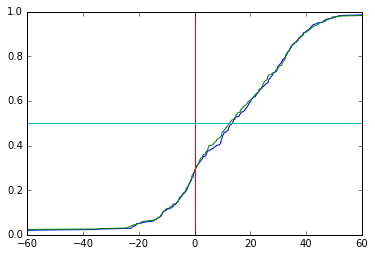

In [163]:
plot_ecdf(mrtt_pid["6bias_udp"])
plot_ecdf(mrtt_pid["6bias_tcp"])
plt.plot((0,0),(0,1))
plt.plot((-60,60),(.5,.5))
plt.xlim(-60,60)

(-10, 10)

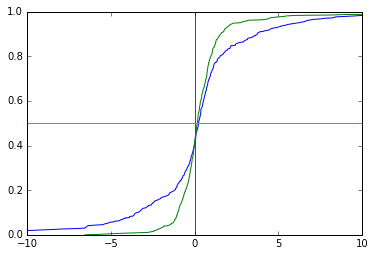

In [164]:
plot_ecdf(mrtt_pid["udpbias_4"])
plot_ecdf(mrtt_pid["udpbias_6"])
plt.plot((0,0),(0,1))
plt.plot((-10,10),(.5,.5))
plt.xlim(-10,10)

pid    dip                         proto
13     193.0.19.107                TCP       -1.000000
                                   UDP       20.657812
       2001:67c:2e8:11::c100:136b  TCP       -1.000000
                                   UDP       21.116500
       203.133.248.56              TCP      327.672000
                                   UDP      325.984771
       2401:2000:6660::56          TCP      328.277563
                                   UDP      327.288083
15     193.0.19.107                TCP        2.469938
                                   UDP        3.269313
       2001:67c:2e8:11::c100:136b  TCP        2.601875
                                   UDP        2.982854
       203.133.248.56              TCP      335.399396
                                   UDP      337.730583
       2401:2000:6660::56          TCP      318.688687
                                   UDP      318.934688
43     193.0.19.107                TCP       -1.000000
                        

,msm_id,time,af,proto,pid,sip,dip,reached,hop,rtt,n
0,3354201,1453140037,4,UDP,1388,172.16.20.100,193.0.19.107,True,9,41.622,1
1,3354201,1453140043,4,UDP,1461,192.168.1.100,193.0.19.107,True,6,38.566,1
2,3354201,1453140043,4,UDP,15,10.2.0.48,193.0.19.107,True,3,4.246,1
3,3354201,1453140035,4,UDP,2079,10.0.0.65,193.0.19.107,True,8,32.626,1
4,3354201,1453140036,4,UDP,213,213.128.135.169,193.0.19.107,True,7,21.816,1
5,3354201,1453140040,4,UDP,2168,192.168.1.214,193.0.19.107,True,10,26.061,1
6,3354201,1453140043,4,UDP,226,203.10.60.131,193.0.19.107,True,14,319.010,1
7,3354201,1453140041,4,UDP,237,10.2.0.29,193.0.19.107,True,3,2.762,1
8,3354201,1453140041,4,UDP,2443,192.168.178.26,193.0.19.107,True,10,46.874,1
9,3354201,1453140010,4,UDP,2596,192.168.1.143,193.0.19.107,True,9,42.951,1


### map broken probes (for fun)

In [ ]:
# determine brokenness by country
cc_probe_count = pd.DataFrame(data = {'all': pdf_tcsdf.groupby('cc')['n'].sum(),
                                      'no_udp': pdf_noudp.groupby('cc')['n'].sum()} ).fillna(0)   

cc_probe_count['badness'] = cc_probe_count["no_udp"] / cc_probe_count["all"]
cc_probe_count.sort('badness')
cc_probe_count.loc['US']

In [ ]:
# map of country codes to shapes
import shapefile
world_sf = shapefile.Reader("data_cache/world/simple")
world_cc = {}
for sr in world_sf.shapeRecords():
    world_cc[sr.record[1]] = sr.shape

In [ ]:
# world map, colored with badness

from mpl_toolkits.basemap import Basemap
from matplotlib.collections import LineCollection

# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.
plt.figure(figsize=(15,12))
plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.15,hspace=0.05)
ax = plt.subplot(111)
m = Basemap(projection='robin',lon_0=0,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='0.9', lake_color='0.95')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,360.,60.))
#x,y = m(pdf_tcsdf['lon'].values,pdf_tcsdf['lat'].values)
#ax.scatter(x,y,alpha=0.1,color="red")

for cc in cc_probe_count.index.values:
    try:
        # set color based on data
        color = (1.0, 1.0 - cc_probe_count.loc[cc]['badness'], 1.0 - cc_probe_count.loc[cc]['badness'])
        
        # now parse the shape into a set of projected line segments
        shape = world_cc[cc]
        polys = [[]]
        for n,p in enumerate(shape.points):
            # Check to see if we have a new polygon
            if n in shape.parts and len(polys[-1]) > 0:
                polys.append([])
            x,y = m(*p)
            polys[-1].append((x,y))
        lines = LineCollection(polys, antialiaseds=(1,))
        lines.set_facecolors(color)
        lines.set_edgecolors((0.2,0,0))
        lines.set_linewidth(.5)
        ax.add_collection(lines)
    except KeyError:
        print("KeyError for "+cc)
        pass
    
#m.drawmapboundary(fill_color='0.95')


plt.title("Distribution of UDP Blocking per Country")
#plt.show()

# Scratch code

Sandbox, dirtpile, etc

In [ ]:
pdf_noudp

In [ ]:
len(tcsdf_target_udp_ok.groupby('pid')['reached'].sum())

In [ ]:
plot_ecdf(tcsdf.groupby('pid').reached.sum() / tcsdf.groupby('pid').n.sum())

In [ ]:
plot_ecdf(pdf_noudp['minhop'])
plot_ecdf(pdf_['maxhop'])
plt.xlim(0,32)

In [ ]:
plot_ecdf(tcsdf[tcsdf['reached']]['hop'])
plot_ecdf(tcsdf[np.logical_not(tcsdf['reached'])]['hop'])

In [ ]:
calendar.timegm((2015,1,1,0,0,0))

In [ ]:
pdf['n'] = 1
pdf_noudp['n'] = 1

In [ ]:
as_probe_count = pd.DataFrame(data = {'all': pdf.groupby('asn4')['n'].sum(),
                                      'no_udp': pdf_noudp.groupby('asn4')['n'].sum()} ).dropna()   

In [ ]:
cc_probe_count["udp_brokenness"] = cc_probe_count['no_udp'] / cc_probe_count['all']
as_probe_count["udp_brokenness"] = as_probe_count['no_udp'] / as_probe_count['all']

In [ ]:
as_probe_count.sort("udp_brokenness")

In [ ]:
cc_probe_count.sort("udp_brokenness")

In [ ]:
tcsdf.groupby('probe')